In [107]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
# from torch.optim import lr_scheduler
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
# import torch.nn.functional as F
import numpy as np
import math


''' Device config'''
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

''' Parameters (CHange Anything Here!) '''
torch.manual_seed(10)
transform = transforms.ToTensor()
batch_size = 100
# lifetime Sparcity
k_rate = 0.5

''' Code Starts Here '''
# Data MNIST
mnist_data = datasets.MNIST(root='./data', train = True, download = True, transform = transform)
data_loader = torch.utils.data.DataLoader(dataset= mnist_data, batch_size = batch_size, shuffle = True)
dataiter = iter(data_loader)


''' Conv 2d Layer 
#         Accessible Variables: .weights(Tensor), .bias(Tensor)
#         parameters :
#         torch.nn.Conv2d(in_channels, out_channels, 
#                         kernel_size, stride=1, padding=0, 
#                         dilation=1, groups=1, bias=True, 
#                         padding_mode='zeros')
'''
# CONV-WTA CRITERIA
# - zero padded, so that each feature map has the same size as the input
# - hidden representation is mapped linearly to the output using a deconvolution operation
# - Parameters are optimized to reduce the mean squared error MSE
# - Conv layer is 5 x5, DECONVOLUTION layer is using filters of 11x 11
### In this implementation, I will not use deconvolution, but transpose convolution to ease process
class Competitive_Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        #Image size:N, 28, 28
        self.conv1      = nn.Conv2d(1, 128, 5, stride=1, padding = 2)  # size:N, 28, 28
        self.conv2      = nn.Conv2d(128, 128, 5, stride=1, padding = 2)  # size:N, 28, 28
        self.transConv1 = nn.ConvTranspose2d(in_channels=128, out_channels=1, kernel_size=11, stride =1, padding = 5) # padding will decrease output size # size:N, 28, 28
#         self.conv1.apply(self.init_weights)
#         self.conv2.apply(self.init_weights)
#         self.transConv1.apply(self.init_weights)
        
#     def init_weights(m):
#         torch.nn.init.xavier_uniform(m.weight)
#         m.bias.data.fill_(0.01)    
    
    def forward(self, x):
        encoded = self.conv1(x) # encode, output: torch.Size([num_batches, num_channels, 28, 28])
        hidden = self.conv2(encoded)
        b4hidden = hidden.clone()
        winner = self.spatial_sparsity_(hidden)
#         print(hidden.shape)
#         hidden = self.lifetime_sparsity_(hidden, winner, k_rate)
        decoded = self.transConv1(hidden)
        return encoded, b4hidden, hidden, decoded

#     def reconstruct(self, x):
#         encoded = nn.ReLU(self.conv1(x)) # encode, output: torch.Size([3, 2, 28, 28])
#         decoded = torch.sigmoid(self.transConv1(hidden))
#         return decoded
    
    # Spatial Sparsity reconstructs the activation map, remain only one winner neuron of each feature map and rest to 0
    # with torch.no_grad() temporarily sets all of the requires_grad flags to false
    def spatial_sparsity_(self, hiddenMaps):
        with torch.no_grad():
            shape = hiddenMaps.shape  #torch.Size([batch_size, feature_num, 26, 26])
            n_batches = shape[0]
            n_features = shape[1]
            size = shape[2]
            
            # Step 1: flatten it out, find max_vals
            flatten = hiddenMaps.view(n_batches, n_features, -1)
            maxval, _ = torch.max(flatten, 2) # max_val return size[n_batches, n_features]
            
            # Step 2: creating "drop" Array to be multiplied into featureMaps, dropping loser values
            maxval_p = torch.reshape(maxval, (n_batches, n_features, 1, 1))
            drop = torch.where(hiddenMaps < maxval_p, 
                               torch.zeros((n_batches, n_features, size, size)).to(device), 
                               torch.ones((n_batches,n_features, size, size)).to(device))
        
        # To retain the graph, use .data to only modify the data of the tensor
        hiddenMaps.data = hiddenMaps.data*drop.data
        return maxval
        
    # Only retain the top-k percent of the winners for every feature. The rest will be zeroed out
    def lifetime_sparsity_(self, hiddenMaps, maxval, k_percent):
        with torch.no_grad():
            shape = hiddenMaps.shape  #torch.Size([batch_size, feature_num, 26, 26])
            n_batches = shape[0]
            n_features = shape[1]
            size = shape[2]
            k = math.floor(n_batches * k_percent)
            
            top_k, _ = torch.topk(maxval, k, 0) 

            # Step 2: creating "drop" Array to be multiplied into featureMaps, dropping loser values
            drop = torch.where(maxval < top_k[k-1:k, :],  
                               torch.zeros((n_batches, n_features)).to(device), 
                               torch.ones((n_batches, n_features)).to(device))

        # To retain the graph, use .data to only modify the data of the tensor
        hiddenMaps.data = hiddenMaps.data * drop.reshape(n_batches, n_features, 1, 1).data
        return hiddenMaps
    

In [108]:
model = Competitive_Autoencoder().to(device)
img, _ = next(dataiter)

encoded, b4hidden, hidden, decoded = model(img)
# kernels = hidden[0:1:,0:1,:,:].detach().clone()
# print(kernels.shape)
# filter_img = torchvision.utils.make_grid(kernels, nrow = 12)
# # # change ordering since matplotlib requires images to 
# # # be (H, W, C)
# print(filter_img.shape)
# plt.imshow(filter_img.permute(1, 2, 0))
# # plt.subplot(2, 9, 9)
# # plt.imshow(decoded[0][0].detach())
print("Encoded: ", encoded.grad_fn)
# print("Hiddenb4: ", b4hidden)
print("Hidden: ", hidden.grad_fn)
print("Decoded: ", decoded.grad_fn)

Encoded:  <MkldnnConvolutionBackward object at 0x000001A4145B6100>
Hidden:  <MkldnnConvolutionBackward object at 0x000001A411CCC5E0>
Decoded:  <SlowConvTranspose2DBackward object at 0x000001A4145B6100>


[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.26152986]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]


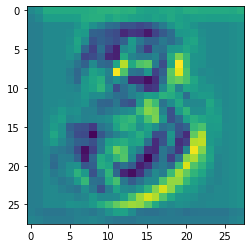

In [118]:
plt.imshow(b4hidden[0][0].detach())
# print(b4hidden[0][0][0:20, 0:20])
npu=b4hidden[0][0][5:10, 15:20].detach().numpy()
print(np.where(npu>0.26, npu, 0))

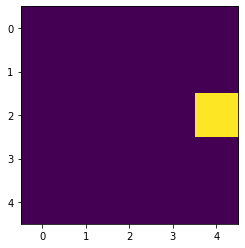

In [112]:
plt.imshow(hidden[0][0][5:10, 15:20].detach())

In [ ]:
hiddenMaps = encoded
with torch.no_grad():
    shape = hiddenMaps.shape  #torch.Size([batch_size, feature_num, 28, 28])
    n_batches = shape[0]
    n_features = shape[1]
    size = shape[2]

    # Step 1: flatten it out, find max_vals
    flatten = hiddenMaps.view(n_batches, n_features, -1)
    maxval, _ = torch.max(flatten, 2) # max_val return size[n_batches, n_features]

    # Step 2: creating "drop" Array to be multiplied into featureMaps, dropping loser values
    maxval_p = torch.reshape(maxval, (n_batches, n_features, 1, 1))
    drop = torch.where(hiddenMaps < maxval_p, 
                       torch.zeros((n_batches, n_features, size, size)).to(device), 
                       torch.ones((n_batches,n_features, size, size)).to(device))